In [1]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import contextily as ctx

In [2]:
df = pd.read_csv("apartments.csv")
pts_col = []

df = df[df["PropertyClass"] == "Residential"] # select residential properties

df = pd.DataFrame(df.groupby(["XCoord", "YCoord", "PropertyUse"], as_index=False).agg({"Bedrooms": 'sum'}))
for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["PropertyUse", "geometry", "Bedrooms"]] 
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


PropertyUse                    geometry  Bedrooms
0      Vacant  POINT (-89.57086 43.06988)         0
1      Vacant  POINT (-89.56982 43.06777)         0
2      Vacant  POINT (-89.56940 43.06827)         0
3      Vacant  POINT (-89.56920 43.06845)         0
4      Vacant  POINT (-89.56915 43.06757)         0

In [3]:
census_df = pd.read_csv("census/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012007"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total", "P012004": "5-9yr", "P012005": "10-14yr", "P012006": "15-17yr", "P012007": "18-19yr"}, inplace=False)
census_df = census_df[1:]
census_df["Total"] = census_df["Total"].astype(int)
census_df["5-9yr"] = census_df["5-9yr"].astype(int)
census_df["10-14yr"] = census_df["10-14yr"].astype(int)
census_df["15-17yr"] = census_df["15-17yr"].astype(int)
census_df["18-19yr"] = census_df["18-19yr"].astype(int)
census_df["18yr_est"] = census_df["18-19yr"].astype(int) * 0.5
census_df["K-12"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"] + census_df["18yr_est"]
census_df = census_df[census_df["K-12"] != 0]
census_df.head()

GEO_ID  \
2  1000000US550250012003019   
3  1000000US550250125021027   
4  1000000US550250008002013   
6  1000000US550250131002034   
8  1000000US550250122021016   

                                                Area  Total  5-9yr  10-14yr  \
2  Block 3019, Block Group 3, Census Tract 12, Da...     22      0        0   
3  Block 1027, Block Group 1, Census Tract 125.02...     25      1        1   
4  Block 2013, Block Group 2, Census Tract 8, Dan...     40      1        1   
6  Block 2034, Block Group 2, Census Tract 131, D...     26      0        3   
8  Block 1016, Block Group 1, Census Tract 122.02...     99      3        4   

   15-17yr  18-19yr  18yr_est  K-12  
2        1        0       0.0   1.0  
3        0        0       0.0   2.0  
4        0        0       0.0   2.0  
6        1        0       0.0   4.0  
8        1        0       0.0   8.0

In [4]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("dane/dane.shp")
dane["GEO_ID"] = "1000000US" + dane["GEOID20"] 
dane.head()

STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
0        55        025    002900      2006  550250029002006  Block 2006   
1        55        025    012700      1050  550250127001050  Block 1050   
2        55        025    011404      4001  550250114044001  Block 4001   
3        55        025    000504      3015  550250005043015  Block 3015   
4        55        025    001200      4020  550250012004020  Block 4020   

  MTFCC20  UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20  \
0   G5040  None   None     None          S    38858         0  +43.0614916   
1   G5040  None   None     None          S  1055458         0  +43.0221242   
2   G5040  None   None     None          S    47453         0  +43.1937131   
3   G5040  None   None     None          S     8739         0  +43.0307340   
4   G5040  None   None     None          S     7686         0  +43.0644947   

     INTPTLON20                                           geometry  \
0  -089.3182030  POLYGON ((-89.31992 43.06209, -89.31823 43.062...   
1  -089.8262570  POLYGON ((-89.83427 43.02107, -89.83427 43.021...   
2  -089.2948433  POLYGON ((-89.29664 43.19458, -89.29664 43.194...   
3  -089.5300742  POLYGON ((-89.53060 43.03119, -89.52971 43.031...   
4  -089.4064235  POLYGON ((-89.40721 43.06476, -89.40698 43.064...   

                     GEO_ID  
0  1000000US550250029002006  
1  1000000US550250127001050  
2  1000000US550250114044001  
3  1000000US550250005043015  
4  1000000US550250012004020

In [5]:
dane.to_crs(df.crs, inplace=True)
block_with_apartment = gpd.sjoin(df, dane, op="within")
block_with_apartment.head()

PropertyUse                    geometry  Bedrooms  index_right STATEFP20  \
0      Vacant  POINT (-89.57086 43.06988)         0         8550        55   
1      Vacant  POINT (-89.56982 43.06777)         0         8550        55   
2      Vacant  POINT (-89.56940 43.06827)         0         8550        55   
3      Vacant  POINT (-89.56920 43.06845)         0         8550        55   
4      Vacant  POINT (-89.56915 43.06757)         0         8550        55   

  COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20 MTFCC20  UR20  \
0        025    010906      1017  550250109061017  Block 1017   G5040  None   
1        025    010906      1017  550250109061017  Block 1017   G5040  None   
2        025    010906      1017  550250109061017  Block 1017   G5040  None   
3        025    010906      1017  550250109061017  Block 1017   G5040  None   
4        025    010906      1017  550250109061017  Block 1017   G5040  None   

  UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20    INTPTLON20  \
0   None     None          S   325276         0  +43.0692763  -089.5664965   
1   None     None          S   325276         0  +43.0692763  -089.5664965   
2   None     None          S   325276         0  +43.0692763  -089.5664965   
3   None     None          S   325276         0  +43.0692763  -089.5664965   
4   None     None          S   325276         0  +43.0692763  -089.5664965   

                     GEO_ID  
0  1000000US550250109061017  
1  1000000US550250109061017  
2  1000000US550250109061017  
3  1000000US550250109061017  
4  1000000US550250109061017

In [6]:
# Assumption: the proportion of bedrooms in the block is the same as the proportion of K-12 children in the block. 

merged = pd.merge(block_with_apartment, census_df, on="GEO_ID")
K12_df = merged[["PropertyUse","Bedrooms", "geometry", "GEOID20", "NAME20", "Total","K-12"]]
#K12_df = merged[["PropertyUse","Bedrooms", "geometry", "NAME20", "Total", "K-12", "GEO_ID"]]

# tmp = K12_df.drop_duplicates(["GEO_ID"])
# K12_Block_total_dict = tmp.groupby(["NAME20"], as_index=False).agg({"K-12":'sum'}).set_index("NAME20")["K-12"].to_dict()
# Block_total_bed_dict = K12_df.groupby(["NAME20"], as_index=False).agg({"Bedrooms":'sum'}).set_index("NAME20")["Bedrooms"].to_dict()
# K12_df["K-12"] = K12_df["K-12"].astype(float)
# for index,row in K12_df.iterrows():
#     if Block_total_bed_dict[row["NAME20"]] == 0:
#         K12_df.at[index, 'K-12'] = 0
#     else:
#         predict_kid = float(row["Bedrooms"]) / float(Block_total_bed_dict[row["NAME20"]]) * K12_Block_total_dict[row["NAME20"]]
#         K12_df.at[index, 'K-12'] = predict_kid
        
# K12_df = K12_df[K12_df["Bedrooms"] != 0]
tract_bedrooms = K12_df.groupby(['GEOID20']).sum()['Bedrooms']
tract_bedrooms = pd.DataFrame(tract_bedrooms).rename(columns = {'Bedrooms': 'Bedrooms in tract'})
merged = pd.merge(K12_df, tract_bedrooms, on="GEOID20")
merged = merged[merged['Bedrooms in tract'] != 0]
merged['K-12-est'] = merged['Bedrooms'] * merged['K-12'] / merged['Bedrooms in tract']
K12_df = merged
K12_df = K12_df[K12_df["Bedrooms"] != 0]
K12_df.head()

PropertyUse  Bedrooms                    geometry          GEOID20  \
0  Single family         3  POINT (-89.55219 43.03171)  550250109031002   
1  Single family         4  POINT (-89.55193 43.03207)  550250109031002   
3  Single family         4  POINT (-89.55156 43.03182)  550250109031002   
4  Single family         4  POINT (-89.55152 43.03266)  550250109031002   
5  Single family         4  POINT (-89.55120 43.03171)  550250109031002   

       NAME20  Total  K-12  Bedrooms in tract  K-12-est  
0  Block 1002     38   4.0                396  0.030303  
1  Block 1002     38   4.0                396  0.040404  
3  Block 1002     38   4.0                396  0.040404  
4  Block 1002     38   4.0                396  0.040404  
5  Block 1002     38   4.0                396  0.040404

## Plots 

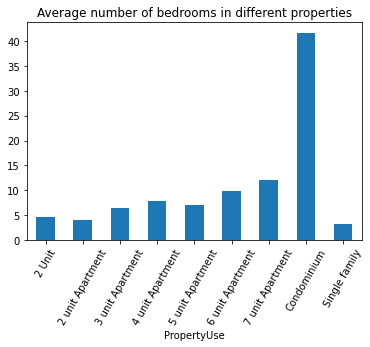

In [7]:
# simple bar plot: #bedrooms in apartments, #bedrooms in single fam, #bedrooms in condos
plot1_df = K12_df.groupby(["PropertyUse"]).mean()
plot1_df["Bedrooms"].plot.bar(title="Average number of bedrooms in different properties", rot=60)

In [8]:
diff_use = pd.DataFrame(K12_df.groupby(['GEOID20', 'PropertyUse']).sum()['Bedrooms'])
diff_use = diff_use.reset_index(level=['GEOID20','PropertyUse'])
diff_use = diff_use.pivot(index='GEOID20', columns='PropertyUse', values='Bedrooms')
diff_use = diff_use.fillna(0)

train_df = pd.merge(K12_df[['GEOID20', 'K-12']], diff_use, on='GEOID20')
train_df

# TODO: 
# then we can use this df to fit K-12 ~ [2-unit, 3 unit, ...., 7 unit, Condo.., Single family]
# get the coefficients for each one
# use the coefficient to estimate K-12 number by propertyUSe. 
# For example, if the coefficient for single family is 0.l, we use 0.1 to multiply the number of bedrooms
# in single family to estimate K-12 number. 

GEOID20  K-12  2 Unit  2 unit Apartment  3 unit Apartment  \
0      550250109031002   4.0     0.0               0.0               0.0   
1      550250109031002   4.0     0.0               0.0               0.0   
2      550250109031002   4.0     0.0               0.0               0.0   
3      550250109031002   4.0     0.0               0.0               0.0   
4      550250109031002   4.0     0.0               0.0               0.0   
...                ...   ...     ...               ...               ...   
29834  550250105011009   4.5     0.0               0.0               0.0   
29835  550250105011009   4.5     0.0               0.0               0.0   
29836  550250105011009   4.5     0.0               0.0               0.0   
29837  550250105011009   4.5     0.0               0.0               0.0   
29838  550250105011009   4.5     0.0               0.0               0.0   

       4 unit Apartment  5 unit Apartment  6 unit Apartment  7 unit Apartment  \
0                   0.0               0.0               0.0               0.0   
1                   0.0               0.0               0.0               0.0   
2                   0.0               0.0               0.0               0.0   
3                   0.0               0.0               0.0               0.0   
4                   0.0               0.0               0.0               0.0   
...                 ...               ...               ...               ...   
29834               0.0               0.0               0.0               0.0   
29835               0.0               0.0               0.0               0.0   
29836               0.0               0.0               0.0               0.0   
29837               0.0               0.0               0.0               0.0   
29838               0.0               0.0               0.0               0.0   

       Condominium  Single family  
0              0.0          396.0  
1              0.0          396.0  
2              0.0          396.0  
3              0.0          396.0  
4              0.0          396.0  
...            ...            ...  
29834          0.0           28.0  
29835          0.0           28.0  
29836          0.0           28.0  
29837          0.0           28.0  
29838          0.0           28.0  

[29839 rows x 11 columns]

Text(0, 0.5, 'Non-Apartment Property percentage')

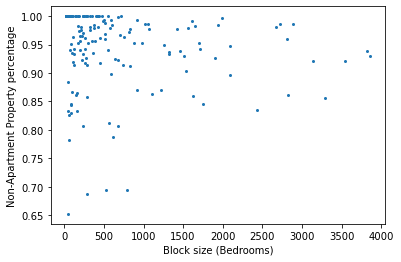

In [9]:
# x-axis is block size (in bedrooms), y-axis is percent of bedrooms in apartments
total_df = K12_df.groupby(["NAME20"]).sum()
non_apt_df = K12_df.loc[(K12_df["PropertyUse"] == "Single family") | (K12_df["PropertyUse"] == "2 Unit") 
                        | (K12_df["PropertyUse"] == "Condominium")]
non_apt_df = non_apt_df.groupby(["NAME20"]).sum()
non_apt_p = non_apt_df["Bedrooms"] / total_df["Bedrooms"]
total_df["Non-Apt(%)"] = non_apt_p
ax = total_df.plot.scatter(x="Bedrooms", y="Non-Apt(%)", s=4)
ax.set_xlabel("Block size (Bedrooms)")
ax.set_ylabel("Non-Apartment Property percentage")

In [10]:
# x-axis is block size, y-axis is average age

Text(0, 0.5, 'K-12 children percentage')

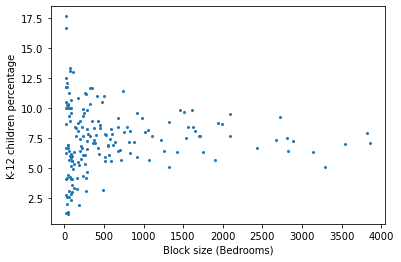

In [11]:
# x-axis is block size, y-axis is % who K-12
pop_df = K12_df.groupby(["NAME20", "GEOID20", "Total"]).sum()
pop_df.reset_index(level=['Total'], inplace=True)
pop_df = pop_df.groupby(['NAME20']).sum()
pop_df["K-12(%)"] = 100* pop_df["K-12-est"] / pop_df["Total"]
ax = pop_df.plot.scatter(x="Bedrooms", y="K-12(%)", s=4)
ax.set_xlabel("Block size (Bedrooms)")
ax.set_ylabel("K-12 children percentage")

## Apartments That Have K-12 Kids

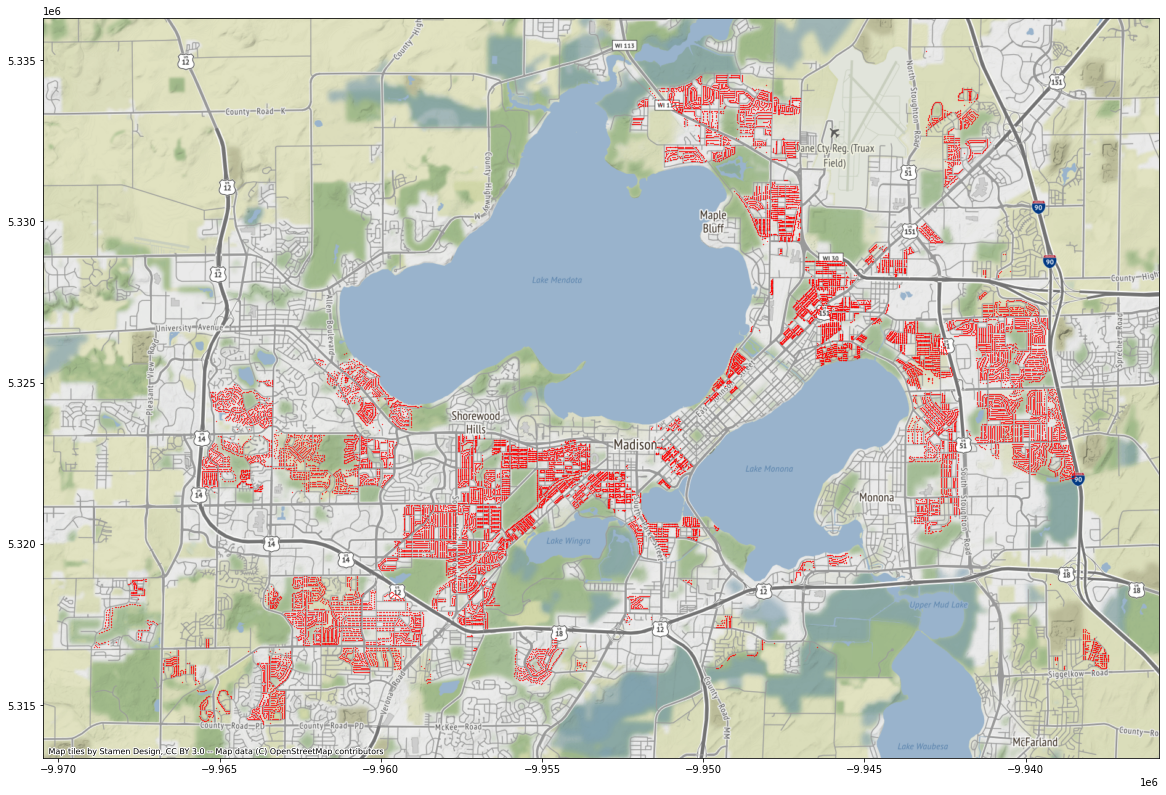

In [12]:
K12_df = K12_df.to_crs(epsg=3857)
ax_k12 = K12_df.plot(markersize=0.1, figsize=(20,20), color="red")
ax2 = ctx.add_basemap(ax_k12)

## Point size by K-12 kids number

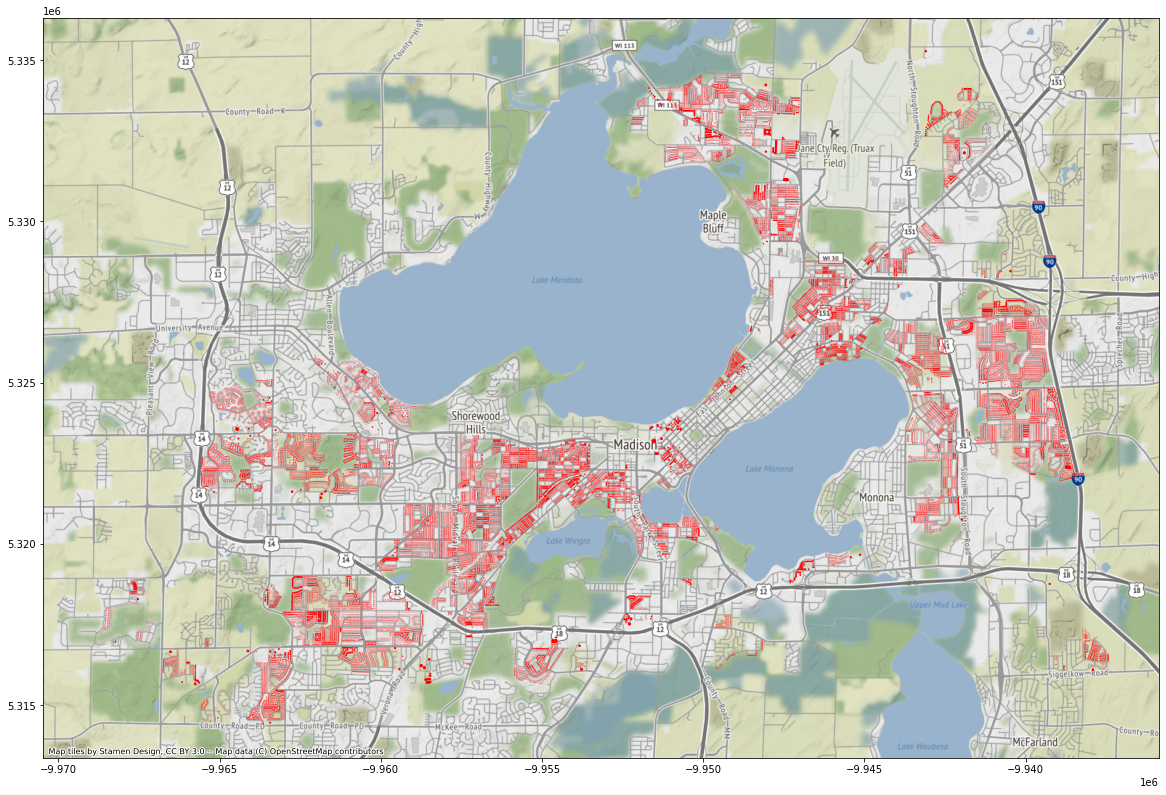

In [15]:
ax_k12_with_size = K12_df.plot(markersize=K12_df["K-12-est"]/4, figsize=(20,20), color="red")
ax3 = ctx.add_basemap(ax_k12_with_size)

## All Apartments in City of Madison

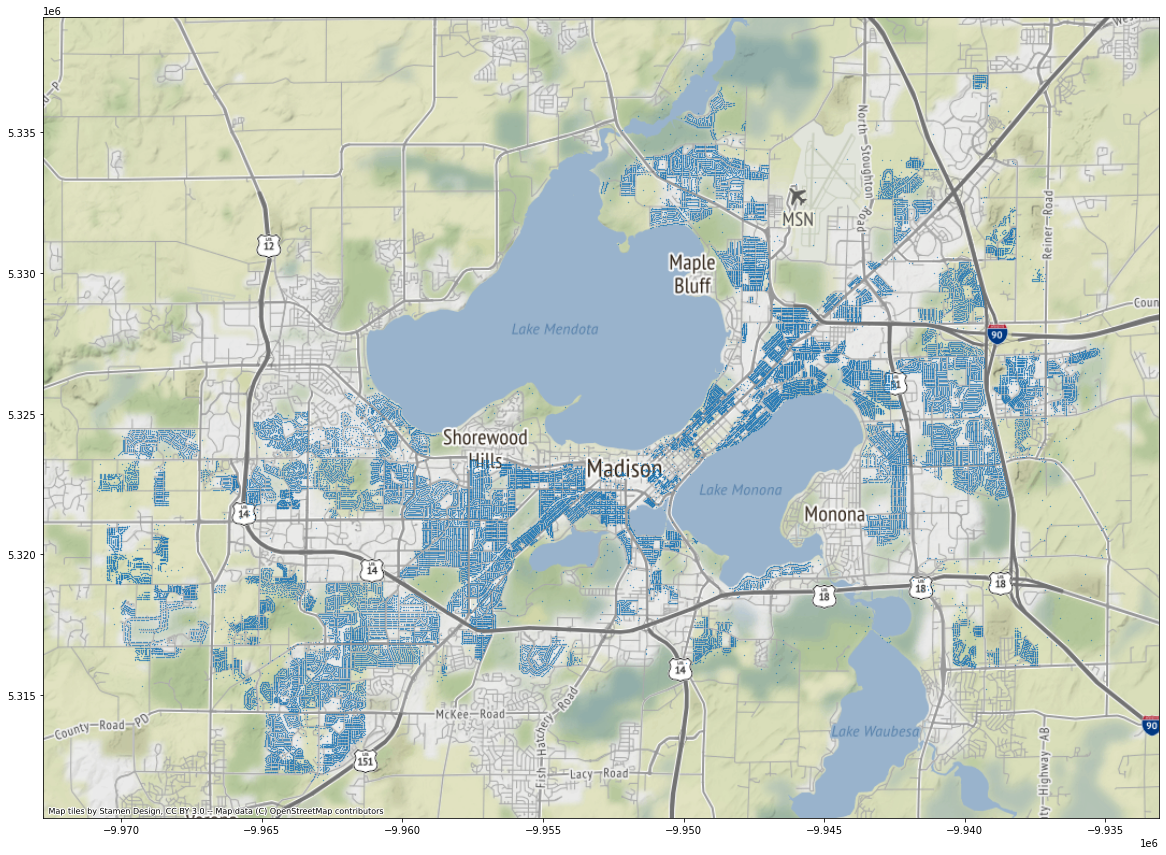

In [14]:
df = df.to_crs(epsg=3857)
ax = df.plot(markersize=0.1, figsize=(20,20))

ctx.add_basemap(ax)